# Chapter 12: Modeling categorical relationships

In [3]:
library(tidyverse)
library(ggplot2)
library(kableExtra)
library(BayesFactor)
library(sfsmisc)
library(cowplot)
theme_set(theme_minimal(base_size = 14))

library(knitr)

set.seed(123456) # set random seed to exactly replicate results

# load the NHANES data library
library(NHANES)

# drop duplicated IDs within the NHANES dataset
NHANES <-
  NHANES %>%
  dplyr::distinct(ID,.keep_all=TRUE)

NHANES_adult <-
  NHANES %>%
  drop_na(Weight) %>%
  subset(Age>=18)


Attaching package: ‘sfsmisc’


The following object is masked from ‘package:dplyr’:

    last




## Table 12.1


In [4]:
candyDf <-
  tibble(
    `Candy Type` = c("chocolate", "licorice", "gumball"),
    count = c(30, 33, 37)
  )
# kable(candyDf, caption='Counts of different candies in our bag.')

# compute chi-squared statistic

candyDf <- candyDf %>%
  mutate(nullExpectation =c(1 / 3, 1 / 3, 1 / 3) * sum(candyDf$count),
         `squared difference`=(count - nullExpectation)**2)
candyDf
# kable(candyDf, digits=3, caption='Observed counts, expectations under the null hypothesis, and squared differences in the candy data')

Candy Type,count,nullExpectation,squared difference
<chr>,<dbl>,<dbl>,<dbl>
chocolate,30,33.33333,11.1111111
licorice,33,33.33333,0.1111111
gumball,37,33.33333,13.4444444


## Figure 12.1

Warning message:
“Removed 11 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


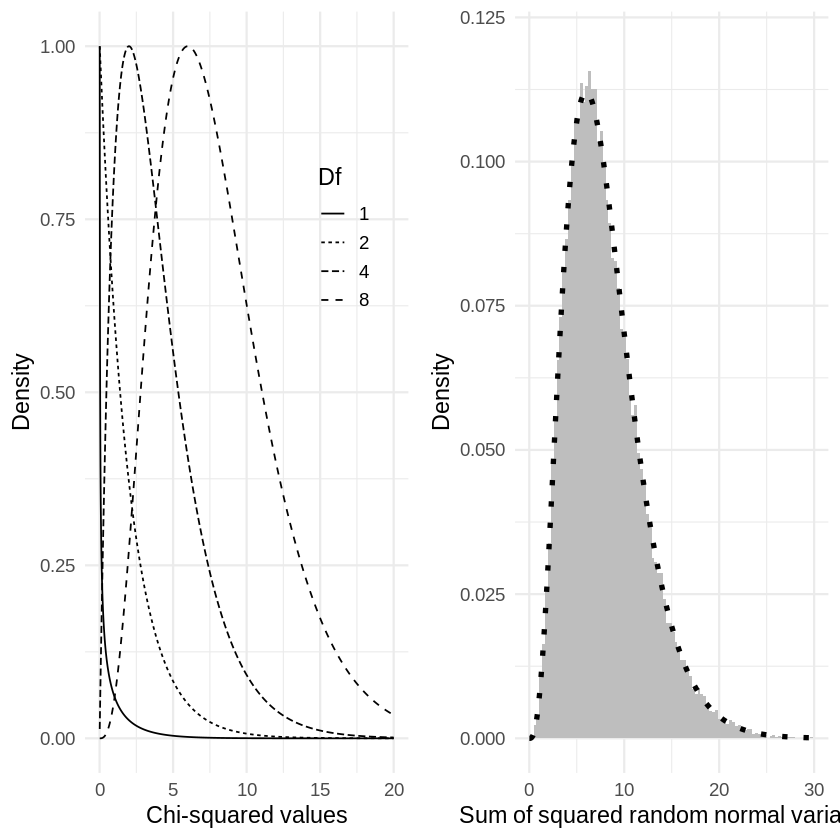

In [6]:
chisqVal <-
  sum(
    ((candyDf$count - candyDf$nullExpectation)**2) / candyDf$nullExpectation
  )

xvals <- seq(0.01, 20, 0.01)
dfvals <- c(1, 2, 4, 8)
chisqDf <-
  data.frame(xvals, dfvals) %>%
  complete(xvals, dfvals)
chisqDf <-
  chisqDf %>%
  mutate(chisq = dchisq(x = xvals, df = dfvals),
         dfvals= as.factor(dfvals)) %>%
  group_by(dfvals) %>%
  mutate(chisqNorm = chisq / max(chisq),
         Df=dfvals
         )


p1 <- ggplot(chisqDf, aes(xvals, chisqNorm, group = Df, linetype = Df)) +
  geom_line() +
  theme(legend.position = c(0.8, 0.7)) +
  labs(
    fill = "Degrees of freedom",
    color = "Degrees of freedom",
    x = "Chi-squared values"
  ) + ylab('Density')


# simulate 50,000 sums of 8 standard normal random variables and compare
# to theoretical chi-squared distribution

# create a matrix with 50k columns of 8 rows of squared normal random variables
d <- replicate(50000, rnorm(n = 8, mean = 0, sd = 1)**2)
# sum each column of 8 variables
dMean <- apply(d, 2, sum)

# create a data frame of the theoretical chi-square distribution
# with 8 degrees of freedom
csDf <-
  data.frame(x = seq(0.01, 30, 0.01)) %>%
  mutate(chisq = dchisq(x, 8))

pval <- pchisq(chisqVal, df = 2, lower.tail = FALSE) #df = degrees of freedom

p2 <- ggplot(data.frame(dMean),aes(dMean)) +
  geom_histogram(aes(y=after_stat(density)),bins=100, fill='gray') +
  geom_line(data=csDf,aes(x,chisq),linetype='dotted',linewidth=1.5)+
  xlim(0,30) + ylim(0,.12) +
  labs(
    y = "Density",
    x = "Sum of squared random normal variables"
  )

plot_grid(p1, p2)

## Table 12.2

In [8]:
# load police stop data after preprocessing using code/process_CT_data.py
stopData <-
  read_csv("https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/CT_data_cleaned.csv",show_col_types = FALSE) %>%
  rename(searched = search_conducted)

# compute and print two-way contingency table
summaryDf2way <-
  stopData %>%
  count(searched, driver_race) %>%
  arrange(driver_race, searched)

summaryContingencyTable <-
  summaryDf2way %>%
  spread(driver_race, n)

# Compute and print contingency table using proportions
# rather than raw frequencies
summaryContingencyTable <-
  summaryContingencyTable %>%
  mutate(
    `Black (relative)` = Black / nrow(stopData), #count of Black individuals searched / total searched
  `White (relative)` = White / nrow(stopData)
  )

summaryContingencyTable


# kable(summaryContingencyTable, digits=3, caption='Contingency table for police search data')

searched,Black,White,Black (relative),White (relative)
<lgl>,<int>,<int>,<dbl>,<dbl>
FALSE,36244,239241,0.129529827,0.85500622
TRUE,1219,3108,0.004356497,0.01110746


## Chi-squared test result

In [9]:
# first, compute the marginal probabilities

# probability of being each race
summaryDfRace <-
  stopData %>%
  count(driver_race) %>% #count the number of drivers of each race
  mutate(
    prop = n / sum(n) #compute the proportion of each race out of all drivers
  )

# probability of being searched
summaryDfStop <-
  stopData %>%
  count(searched) %>% #count the number of searched vs. not searched
  mutate(
    prop = n / sum(n) # compute proportion of each outcome out all traffic stops
  )

# We can use a linear algebra trick known as the "outer product"
# (via the `outer()` function) to compute this easily.
# second, multiply outer product by n (all stops) to compute expected frequencies
expected <- outer(summaryDfRace$prop, summaryDfStop$prop) * nrow(stopData)

# create a data frame of expected frequencies for each race
expectedDf <-
  data.frame(expected, driverRace = c("Black", "White")) %>%
  rename(
    NotSearched = X1,
    Searched = X2
  )

# tidy the data frame
expectedDfTidy <-
  gather(expectedDf, searched, n, -driverRace) %>%
  arrange(driverRace, searched)

# third, add expected frequencies to the original summary table
# and fourth, compute the standardized squared difference between
# the observed and expected frequences

summaryDf2way <-
  summaryDf2way %>%
  mutate(expected = expectedDfTidy$n)

summaryDf2way <-
  summaryDf2way %>%
  mutate(stdSqDiff = (n - expected)**2 / expected)

chisq <- sum(summaryDf2way$stdSqDiff)
pval <- pchisq(chisq, df = 1, lower.tail = FALSE)

#kable(summaryDf2way, digits=2,caption='Summary of the 2-way contingency table for police search data')

# first need to rearrange the data into a 2x2 table
summaryDf2wayTable <-
  summaryDf2way %>%
  dplyr::select(-expected, -stdSqDiff) %>%
  spread(searched, n) %>%
  dplyr::select(-driver_race)

chisqTestResult <- chisq.test(summaryDf2wayTable, 1, correct = FALSE)
chisqTestResult


	Pearson's Chi-squared test

data:  summaryDf2wayTable
X-squared = 828.3, df = 1, p-value < 2.2e-16


## Table 12.4

In [11]:
# compute standardized residuals
summaryDfResids <-
  summaryDf2way %>%
  mutate(`Standardized residuals` = (n - expected)/sqrt(expected)) %>%
  dplyr::select(-n, -expected, -stdSqDiff)

summaryDfResids


searched,driver_race,Standardized residuals
<lgl>,<chr>,<dbl>
FALSE,Black,-3.330746
TRUE,Black,26.576456
FALSE,White,1.309550
TRUE,White,-10.449072


## Bayes factor

In [12]:
# compute Bayes factor
# using independent multinomial sampling plan in which row totals (driver race)
# are fixed

bf <-
  contingencyTableBF(as.matrix(summaryDf2wayTable),
  sampleType = "indepMulti",
  fixedMargin = "cols"
)
bf

Bayes factor analysis
--------------
[1] Non-indep. (a=1) : 1.753219e+142 ±0%

Against denominator:
  Null, independence, a = 1 
---
Bayes factor type: BFcontingencyTable, independent multinomial


## Table 12.5

In [13]:
# summarize depression as a function of sleep trouble
depressedSleepTrouble <-
  NHANES_adult %>%
  drop_na(SleepTrouble, Depressed) %>%
  count(SleepTrouble, Depressed) %>%
  arrange(SleepTrouble, Depressed)

depressedSleepTroubleTable <-
  depressedSleepTrouble %>%
  spread(SleepTrouble, n) %>%
  rename(
    NoSleepTrouble = No,
    YesSleepTrouble = Yes
  )

depressedSleepTroubleTable

#kable(depressedSleepTroubleTable, caption="Relationship between depression and sleep problems in the NHANES dataset")

Depressed,NoSleepTrouble,YesSleepTrouble
<fct>,<int>,<int>
None,2614,676
Several,418,249
Most,138,145


## Chi-squared result

In [14]:
# need to remove the column with the label names
depressedSleepTroubleTable <-
  depressedSleepTroubleTable %>%
  dplyr::select(-Depressed)

depressedSleepChisq <- chisq.test(depressedSleepTroubleTable)
depressedSleepChisq


	Pearson's Chi-squared test

data:  depressedSleepTroubleTable
X-squared = 191.46, df = 2, p-value < 2.2e-16


## Bayes factor

In [15]:
# compute bayes factor, using a joint multinomial sampling plan
bf <-
  contingencyTableBF(
    as.matrix(depressedSleepTroubleTable),
    sampleType = "jointMulti"
  )
bf

Bayes factor analysis
--------------
[1] Non-indep. (a=1) : 1.796345e+35 ±0%

Against denominator:
  Null, independence, a = 1 
---
Bayes factor type: BFcontingencyTable, joint multinomial
